https://blog.paperspace.com/adversarial-autoencoders-with-pytorch/

https://ratsgo.github.io/generative%20model/2018/01/28/VAEs/

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torch.autograd.variable as Variable
from torchvision import transforms
from torchvision.utils import save_image

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cpu')

In [4]:
# Create a directory if not exist
sample_dir = 'samples_AAE'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [5]:
# Hyper-parameters
X_dim = 784   # input image
h_dim = 400   # hidden layer
z_dim = 20
num_epochs = 100
batch_size = 200
learning_rate = 1e-3

In [6]:
# MNIST dataset
dataset = torchvision.datasets.MNIST(root='../../data',
                                    train=True,
                                    transform=transforms.ToTensor(),   # tensor로 transform해서 가져옴
                                    download=True)

Processing...
Done!


In [7]:
# check dataset size
len(dataset)

60000

In [8]:
# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                         batch_size = batch_size,
                                         shuffle=True)

In [9]:
# check batch size
len(data_loader)

300

In [10]:
temp = next(iter(data_loader))

In [11]:
temp[0].shape

torch.Size([200, 1, 28, 28])

In [12]:
temp[1].shape

torch.Size([200])

In [16]:
# Encoder
class Q_net(nn.Module):
    def __init__(self):
        super(Q_net, self).__init__()
        self.lin1 = nn.Linear(X_dim, h_dim)
        self.lin2 = nn.Linear(h_dim, h_dim)
        self.lin3gauss = nn.Linear(h_dim, z_dim)
        
    def forward(self, x):  # (784, 20)
        x = F.dropout(self.lin1(x), p=0.25, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.25, training=self.training)
        x = F.relu(x)
        xgauss = self.lin3gauss(x)
        return xgauss

In [17]:
# Decoder
class P_net(nn.Module):
    def __init__(self):
        super(P_net, self).__init__()
        self.lin1 = nn.Linear(z_dim, h_dim)
        self.lin2 = nn.Linear(h_dim, h_dim)
        self.lin3 = nn.Linear(h_dim, X_dim)
        
    def forward(self, x):  # (20, ) -> (784, )
        x = self.lin1(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.lin3(x)
        return F.sigmoid(x)

In [18]:
# Discriminator
class D_net_gauss(nn.Module):
    def __init__(self):
        super(D_net_gauss, self).__init__()
        self.lin1 = nn.Linear(z_dim, h_dim)
        self.lin2 = nn.Linear(h_dim, h_dim)
        self.lin3 = nn.Linear(h_dim, 1)
        
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.2, training=self.training)
        x = F.relu(x)
        return F.sigmoid(self.lin3(x))

In [19]:
# torch.manual_seed(10)
# Q, P = Q_net() = Q_net(), P_net(0)     # Encoder/Decoder

# model
Q = Q_net().to(device)
P = P_net().to(device)
D_gauss = D_net_gauss().to(device)

In [21]:
# Set learning rates
gen_lr, reg_lr = 0.0006, 0.0008

# Set optimizators
P_decoder = optim.Adam(P.parameters(), lr=gen_lr)
Q_encoder = optim.Adam(Q.parameters(), lr=gen_lr)   # Q_encoder랑 Q_generator는 같은 파라미터를 업데이트하지만, loss가 다름
Q_generator = optim.Adam(Q.parameters(), lr=reg_lr)
D_gauss_solver = optim.Adam(D_gauss.parameters(), lr=reg_lr)

In [24]:
G_loss_list = []

# start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):   # index, (image, label)
        # x shape: (28, 28)
        # Forward pass
        X = x.to(device).view(-1, X_dim)

        ##############################
        # Reconstruction phase
        ##############################
        P_decoder.zero_grad()
        Q_encoder.zero_grad()
        
        z_sample = Q(X)
        X_sample = P(z_sample)

        recon_loss = F.binary_cross_entropy(X_sample + 1e-10, 
                                            X.resize(batch_size, X_dim) + 1e-10)
        recon_loss.backward()
        
        P_decoder.step()
        Q_encoder.step()

        ##############################        
        # Regularication phase
        ##############################
        Q.eval()   # evalutation mode -> train X

        z_real_gauss = Variable(torch.randn(batch_size, z_dim))   # Sample from N(0,1)

        if torch.cuda.is_available():
            z_real_gauss = z_real_gauss.cuda()

        z_fake_gauss = Q(X)
        
        # Compute discriminator outputs and loss
        D_real_gauss, D_fake_gauss = D_gauss(z_real_gauss), D_gauss(z_fake_gauss)
        D_loss_gauss = -torch.mean(torch.log(D_real_gauss + 1e-10) + torch.log(1 - D_fake_gauss + 1e-10))
        
        
        D_gauss_solver.zero_grad()
        D_loss_gauss.backward()       # Backpropagate loss
        D_gauss_solver.step()
        
        # Generator
        Q.train()   # Back to use dropout
        z_fake_gauss = Q(X)
        D_fake_gauss = D_gauss(z_fake_gauss)

        G_loss = -torch.mean(torch.log(D_fake_gauss + 1e-10))
        
        Q_generator.zero_grad()
        G_loss.backward()
        G_loss_list.append(G_loss.item())
        Q_generator.step()   # Apply optimization step
        
        
        if (i+1) % 10 == 0:
            print("Epoch[{}/{}], Step [{}/{}], Recons Loss: {:.4f}, KL Div: {:.4f}"
            .format(epoch+1, num_epochs, i+1, len(data_loader), recon_loss.item(), G_loss.item()))
    
    # 매 epoch 마다
    with torch.no_grad():  # => gradient는 고정시킨 채로 forward하여 샘플링만 해보기
        # Save the sampled images
        # z 생성하고 해당 sample을 비교
        z = torch.randn(batch_size,z_dim).to(device)
        out = P(z).view(-1, 1, 28, 28)  # decode
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/site-packages/torch/tensor.py:263: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.7/site-packages/torch/autograd/__init__.py:167: UserWarning: torch.autograd.variable(...) is deprecated, use torch.tensor(...) instead
  warnings.warn("torch.autograd.variable(...) is deprecated, use torch.tensor(...) instead")


Epoch[1/100], Step [10/300], Recons Loss: 0.2910, KL Div: 0.6969
Epoch[1/100], Step [20/300], Recons Loss: 0.2920, KL Div: 0.6817
Epoch[1/100], Step [30/300], Recons Loss: 0.2943, KL Div: 0.6758
Epoch[1/100], Step [40/300], Recons Loss: 0.2905, KL Div: 0.6886
Epoch[1/100], Step [50/300], Recons Loss: 0.2886, KL Div: 0.7047
Epoch[1/100], Step [60/300], Recons Loss: 0.2761, KL Div: 0.7113
Epoch[1/100], Step [70/300], Recons Loss: 0.2835, KL Div: 0.7184
Epoch[1/100], Step [80/300], Recons Loss: 0.2842, KL Div: 0.7168
Epoch[1/100], Step [90/300], Recons Loss: 0.2685, KL Div: 0.7115
Epoch[1/100], Step [100/300], Recons Loss: 0.2807, KL Div: 0.6999
Epoch[1/100], Step [110/300], Recons Loss: 0.2739, KL Div: 0.6887
Epoch[1/100], Step [120/300], Recons Loss: 0.2702, KL Div: 0.7082
Epoch[1/100], Step [130/300], Recons Loss: 0.2785, KL Div: 0.6932
Epoch[1/100], Step [140/300], Recons Loss: 0.2741, KL Div: 0.6875
Epoch[1/100], Step [150/300], Recons Loss: 0.2732, KL Div: 0.7056
Epoch[1/100], Step 

KeyboardInterrupt: 

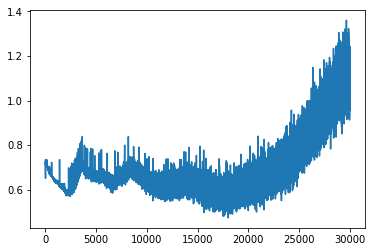

In [54]:
# plot G_loss
import matplotlib.pyplot as plt
plt.plot(range(len(G_loss_list)), G_loss_list)
plt.show()